In [1]:
import itertools as itt
import math
from collections import Counter, defaultdict

import bioregistry
import bioversions
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyobo
import seaborn as sns
from disease import CONFIGURATION, MODULE
from IPython.display import SVG
from matplotlib_inline.backend_inline import set_matplotlib_formats
from pyobo.sources.mesh import get_mesh_category_curies
from tqdm.auto import tqdm

import semra
import semra.api
from semra.analysis.landscape import (
    counter_to_df,
    draw_counter,
    get_directed_index,
    get_summary_df,
    get_symmetric_counts_df,
    get_terms,
    landscape_analysis,
    overlap_analysis,
)
from semra.api import to_multidigraph
from semra.io import from_pickle, from_sssom

/Users/cthoyt/.virtualenvs/indra/lib/python3.11/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
set_matplotlib_formats("svg")

## Summarize the Resources

In [3]:
# some resources are generic, so we want to cut to a relevant subset
subsets = {
    "mesh": [*get_mesh_category_curies("C"), *get_mesh_category_curies("F")],
    "efo": ["efo:0000408"],
    "ncit": ["ncit:C2991"],
}

terms = get_terms(CONFIGURATION.priority, subsets)

In [4]:
summary_df = get_summary_df(priority=CONFIGURATION.priority, terms=terms)
summary_df

,prefix,license,version,terms
0,doid,CC0-1.0,2024-02-28,11511
1,mondo,CC-BY-4.0,2024-03-04,24099
2,efo,Apache-2.0,3.64.0,2082
3,mesh,CC0-1.0,2024,3120
4,ncit,CC-BY-4.0,24.02d,20094
5,orphanet,None,None,0
6,orphanet.ordo,CC-BY-4.0,4.4,0
7,omim,None,"March 26, 2024",0
8,omim.ps,None,"March 26, 2024",0
9,gard,None,None,0


## Summarize the Mappings

In order to summarize the mappings, we're going to load them, index them, and count the number of mappings between each pair of resources. The self-mapping column is the count of terms in the resource. We'll do this to the raw mappings first, then to the processed mappings, then compare them.

In [5]:
overlap_results = overlap_analysis(CONFIGURATION, terms)
overlap_results.write(".")

In [6]:
overlap_results.raw_counts_df

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,
doid,11511,11150,2189,4612,4612,2108,5898,0,2109,0,3528,1,0,2237,470
mondo,11150,24099,3070,8137,7193,9529,9871,582,11838,15,1637,0,4343,2,732
efo,2189,3070,2082,1073,2197,58,850,42,733,804,443,0,1766,7,323
mesh,4612,8137,1073,3120,142,0,0,0,0,0,0,0,0,0,0
ncit,4612,7193,2197,142,20094,0,0,0,0,0,0,0,0,0,0
orphanet.ordo,2108,9529,58,0,0,0,11146,0,0,7623,0,5484,0,0,0
omim,5898,9871,850,0,0,11146,0,0,0,0,0,0,0,0,0
omim.ps,0,582,42,0,0,0,0,0,0,0,0,0,0,0,0
gard,2109,11838,733,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
overlap_results.counts_df

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,
doid,11511,11365,2278,4660,5094,2508,5917,81,2109,11,3599,1,0,2237,470
mondo,11365,24099,3248,8279,7460,9545,9874,583,11839,15,1662,0,4343,4,732
efo,2278,3248,2082,1197,2375,387,872,48,733,805,488,0,1766,7,323
mesh,4660,8279,1197,3120,1585,612,1288,47,1,5,470,0,0,1,0
ncit,5094,7460,2375,1585,20094,585,217,52,2,9,536,0,0,1,0
orphanet.ordo,2508,9545,387,612,585,0,11172,71,1,7623,193,5484,0,1,0
omim,5917,9874,872,1288,217,11172,0,4,2,1,50,0,0,1,0
omim.ps,81,583,48,47,52,71,4,0,1,0,19,0,0,1,0
gard,2109,11839,733,1,2,1,2,1,0,0,1,0,0,1,0


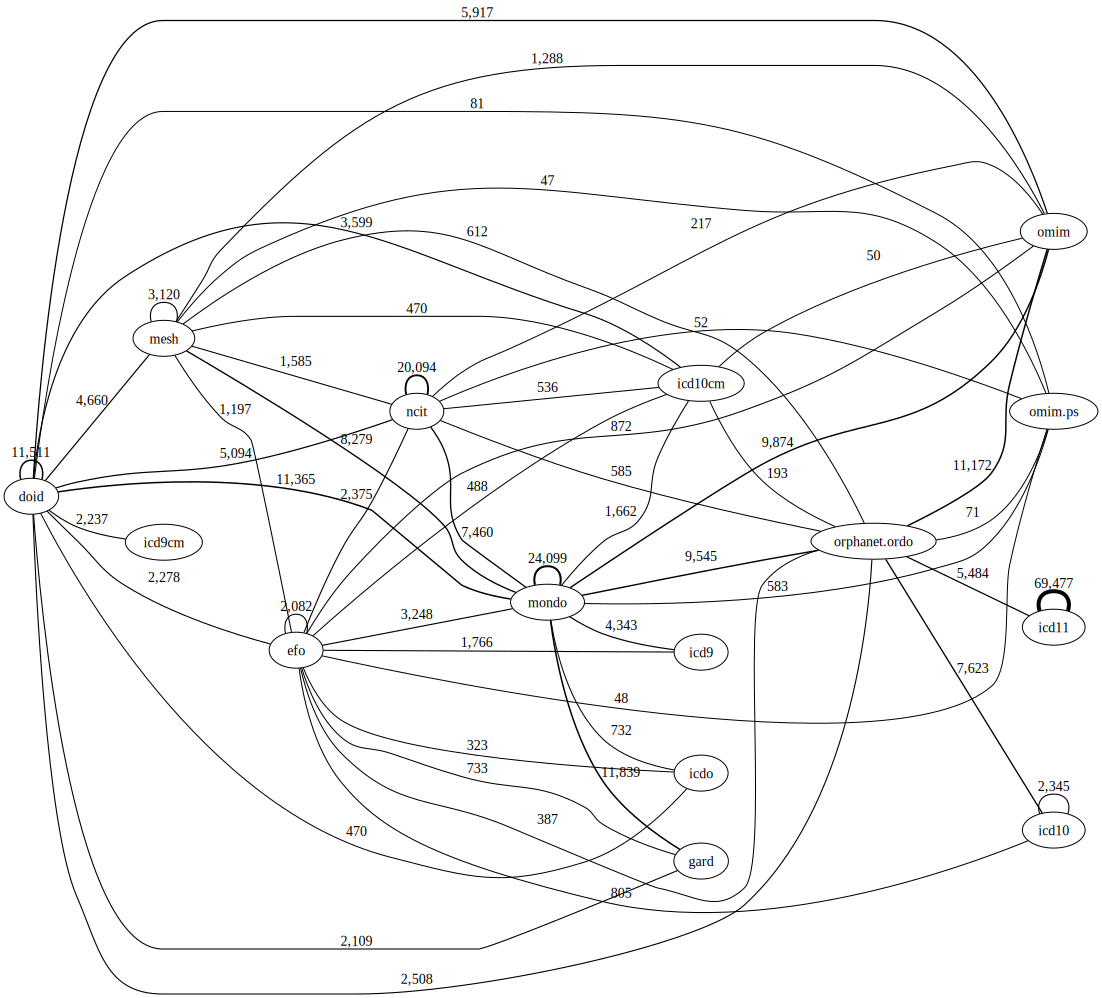

In [8]:
SVG(overlap_results.counts_drawing)

The following comparison shows the absolute number of mappings added by processing/inference. Across the board, this process adds large numbers of mappings to most resources, especially ones that were previously only connected to a small number of other resources (e.g., OMIM).

In [9]:
overlap_results.gains_df

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,
doid,0,215,89,48,482,400,19,81,0,11,71,0,0,0,0
mondo,215,0,178,142,267,16,3,1,1,0,25,0,0,2,0
efo,89,178,0,124,178,329,22,6,0,1,45,0,0,0,0
mesh,48,142,124,0,1443,612,1288,47,1,5,470,0,0,1,0
ncit,482,267,178,1443,0,585,217,52,2,9,536,0,0,1,0
orphanet.ordo,400,16,329,612,585,0,26,71,1,0,193,0,0,1,0
omim,19,3,22,1288,217,26,0,4,2,1,50,0,0,1,0
omim.ps,81,1,6,47,52,71,4,0,1,0,19,0,0,1,0
gard,0,1,0,1,2,1,2,1,0,0,1,0,0,1,0


Here's an alterate view on the number of mappings normalized to show percentage gain. This highlights that some resources (such as NCIT-MeSH) gain a large number of mappings. (Note: UMLS could help this, but mappings from this resource are controversial to reuse).

Note:

- `inf` means that there were no mappings before and now there are a non-zero number of mappings
- `NaN` means there were no mappings before inference and continue to be no mappings after inference

In [10]:
overlap_results.percent_gains_df.round(1)

target_prefix,doid,mondo,efo,mesh,ncit,orphanet.ordo,omim,omim.ps,gard,icd10,icd10cm,icd11,icd9,icd9cm,icdo
source_prefix,,,,,,,,,,,,,,,
doid,0.0,1.9,4.1,1.0,10.5,19.0,0.3,inf,0.0,inf,2.0,0.0,NaN,0.0,0.0
mondo,1.9,0.0,5.8,1.7,3.7,0.2,0.0,0.2,0.0,0.0,1.5,NaN,0.0,100.0,0.0
efo,4.1,5.8,0.0,11.6,8.1,567.2,2.6,14.3,0.0,0.1,10.2,NaN,0.0,0.0,0.0
mesh,1.0,1.7,11.6,0.0,1016.2,inf,inf,inf,inf,inf,inf,NaN,NaN,inf,NaN
ncit,10.5,3.7,8.1,1016.2,0.0,inf,inf,inf,inf,inf,inf,NaN,NaN,inf,NaN
orphanet.ordo,19.0,0.2,567.2,inf,inf,NaN,0.2,inf,inf,0.0,inf,0.0,NaN,inf,NaN
omim,0.3,0.0,2.6,inf,inf,0.2,NaN,inf,inf,inf,inf,NaN,NaN,inf,NaN
omim.ps,inf,0.2,14.3,inf,inf,inf,inf,NaN,inf,NaN,inf,NaN,NaN,inf,NaN
gard,0.0,0.0,0.0,inf,inf,inf,inf,inf,NaN,NaN,inf,NaN,NaN,inf,NaN


# Landscape Coverage

Before, we looked at the overlaps between each resource. Now, we use that information jointly to estimate the number of terms in the landscape itself, and estimate how much of the landscape each resource covers.

In [11]:
# note we're using the sliced counts dataframe index instead of the
# original priority since we threw a couple prefixes away along the way
landscape_results = landscape_analysis(overlap_results.mappings, terms=terms, priority=overlap_results.counts_df.index)

print(landscape_results.describe())

This estimates a total of 105,505 unique entities.
Of these, 16,866 (16.0%) have at least one mapping.
88,639 (84.0%) are unique to a single resource.
2 (0.0%) appear in all 15 resources.

This estimate is susceptible to several caveats:

- Missing mappings inflates this measurement
- Generic resources like MeSH contain irrelevant entities that can't be mapped



/var/folders/vp/n7_7v49n7dl7ln9bs8r0wbt80000gn/T/ipykernel_96052/2612451778.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


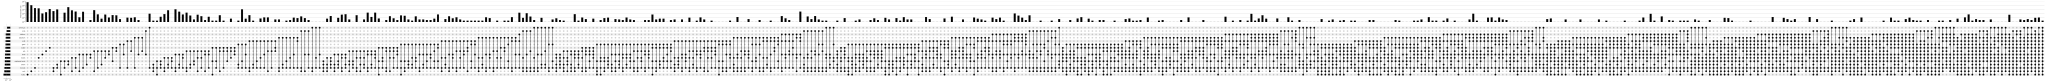

In [12]:
landscape_results.plot_upset()

plt.tight_layout()
plt.savefig("disease_upset.svg")
plt.show()

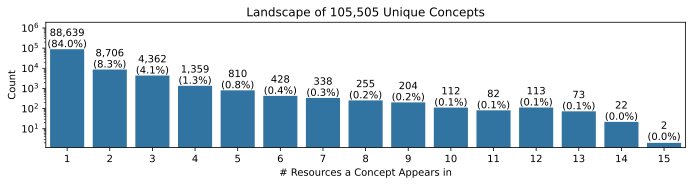

In [13]:
landscape_results.plot_distribution()

plt.tight_layout()
plt.savefig("disease_histogram.svg")
plt.show()